In [26]:
import os
import torch
import random
import requests
import html2text
import wikipedia

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from transformers import (
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    pipeline,
)
from nltk import pos_tag, word_tokenize
from IPython.display import HTML

data_path = "../../data"

In [14]:
root_path = os.path.join(data_path, "okvqa")

test_questions_path = os.path.join(root_path, "OpenEnded_mscoco_val2014_questions.json")
test_annotations_path = os.path.join(root_path, "mscoco_val2014_annotations.json")
test_image_path = os.path.join(root_path, "val2014")
test_image_name_prefix = "COCO_val2014_000000"

with open(test_questions_path, "r") as f:
    test_questions_df = pd.DataFrame(json.load(f)["questions"])
    
with open(test_annotations_path, "r") as f:
    test_annotations_df = pd.DataFrame(json.load(f)["annotations"])
    
test_df = test_questions_df.merge(test_annotations_df)
test_df["image_path"] = test_df["image_id"].map(lambda image_id: os.path.join(test_image_path, f"{test_image_name_prefix}{image_id:06d}.jpg"))

In [35]:
qa_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
qa_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")

ic_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
ic_feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
ic_tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
qa_model = qa_model.to(device)
ic_model = ic_model.to(device)

In [33]:
def read_image(image_path):
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")

    return i_image

def get_wikipedia_page(string):
    try:
        p = wikipedia.summary(string, auto_suggest=False)
    except wikipedia.DisambiguationError as e:
        s = e.options[0]
        p = wikipedia.summary(s, auto_suggest=False)

    return p

def get_context_wikipedia(caption):
    words = word_tokenize(caption)
    tags = pos_tag(words)

    tags = [w for (w, t) in tags if t[0] == "N"]

    options = list(set([o for tag in tags for o in wikipedia.search(tag, results=1)]))
    pages = [caption] + [get_wikipedia_page(option) for option in options]

    return "\n".join(pages)

def get_caption(
    ic_model,
    ic_feature_extractor,
    ic_tokenizer,
    image,
    max_length=16,
    num_beams=4,
):
    pixel_values = ic_feature_extractor(
        images=[image], return_tensors="pt"
    ).pixel_values
    pixel_values = pixel_values.to(ic_model.device)

    output_ids = ic_model.generate(
        pixel_values, max_length=max_length, num_beams=num_beams
    )

    preds = ic_tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds[0]

def get_answer(qa_model, qa_tokenizer, question, context):
    qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=qa_tokenizer)
    result = qa_pipeline(question, context)

    return result

def run(
    ic_feature_extractor,
    ic_model,
    ic_tokenizer,
    qa_model,
    qa_tokenizer,
    image,
    question,
    max_length=16,
    num_beams=4,
):
    caption = get_caption(
        ic_model,
        ic_feature_extractor,
        ic_tokenizer,
        image,
        max_length=max_length,
        num_beams=num_beams,
    )
    context = get_context_wikipedia(caption)
    answer = get_answer(qa_model, qa_tokenizer, question, context)

    return caption, answer, context

def mk_predictions(index):
    question, image_path, answers = test_df[["question", "image_path", "answers"]].iloc[index]
    image = read_image(image_path)
    caption, answer, context = run(ic_feature_extractor, ic_model, ic_tokenizer, qa_model, 
                                   qa_tokenizer, image, question)
    
    plt.imshow(image)
    plt.show()
    print(f"Q: {question}\nC: {caption}\nA: {answer['answer']} (score:{answer['score']})\nGT: {list(set([a['answer'] for a in answers]))}")

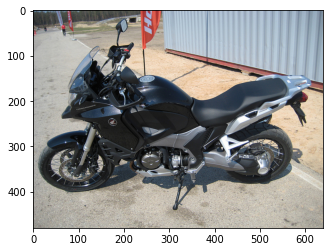

Q: What sport can you use this for?
C: a black motorcycle parked in a parking lot
A: racing (score:0.9859265089035034)
GT: ['ride', 'motocross', 'race']


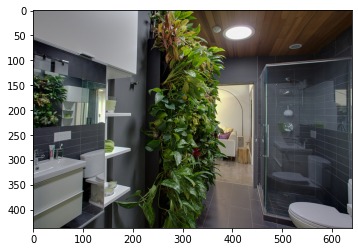

Q: Name the type of plant this is?
C: a bathroom with a toilet, sink, and shower stall
A: porcelain (score:0.47001487016677856)
GT: ['vine', 'look like some kind of ivy', 'climb', 'ficus']


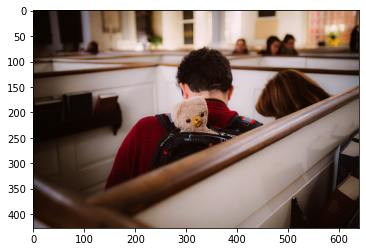

Q: What toy is this?
C: a young boy is holding a teddy bear in his hand
A: teddy bear (score:0.7926927208900452)
GT: ['stuffed animal', 'teddy bear']


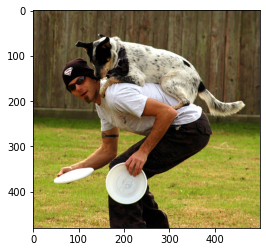

Q: Which part of this animal would be in use of it was playing the game that is played with the items the man is holding?
C: a man holding a frisbee in his right hand
A: dog (score:0.3268183469772339)
GT: ['mouth']


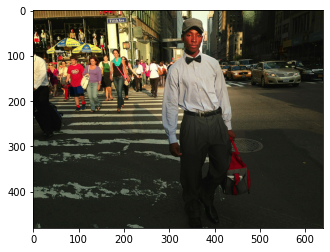

Q: What could this gentleman be carrying in that red bag?
C: a man in a white shirt and black pants holding a knife
A: knife (score:0.46125495433807373)
GT: ['food', 'lunch', 'shoe', 'cloth']


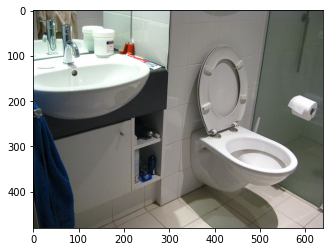

Q: Who leaves a toilet like this?
C: a white toilet sitting in a bathroom next to a sink
A: professional plumbers (score:0.10895466059446335)
GT: ['man', 'men']


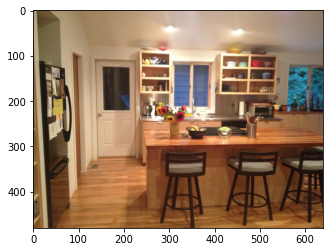

Q: A center affixed unit like this one in a kitchen is called a what?
C: a kitchen with a table, chairs and a refrigerator
A: chair (score:0.3821864426136017)
GT: ['island']


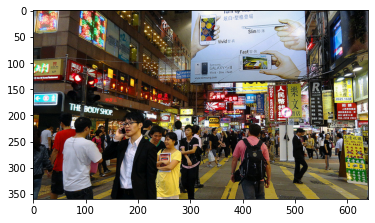

Q: Why might someone go to this place?
C: a crowd of people walking down a city street
A: employment, entertainment, and education (score:0.13717877864837646)
GT: ['business', 'shop', 'nyc']


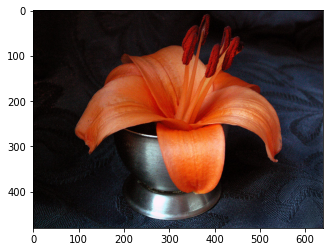

Q: What does this grow from?
C: a flower in a vase on a table
A: flower (score:0.17562611401081085)
GT: ['ground', 'plant', 'hibiscus plant stem', 'root']


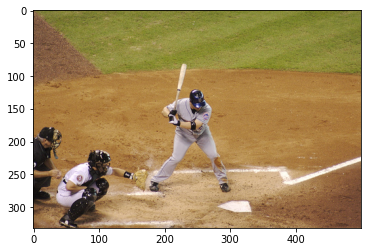

Q: What is that man doing with the bat?
C: a batter, catcher and umpire during a baseball game
A: hit with a bat (score:0.06278453022241592)
GT: ['try to hit hte ball', 'hit', 'swing']


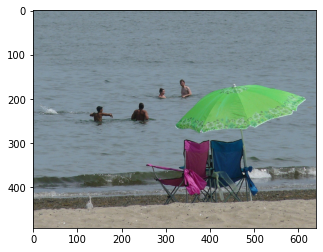

Q: Is this at a salt water beach or a lake?
C: a beach scene with people and umbrellas
A: A beach (score:0.22785142064094543)
GT: ['lake', 'beach', 'salt water', 'salt water beach']


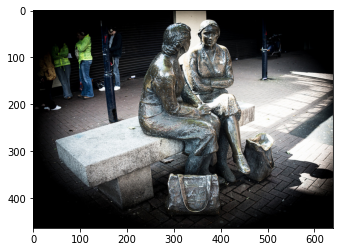

Q: Who designed the statues?
C: a statue of a man sitting on a bench
A: carved or cast in a durable material such as wood, metal or stone (score:0.01409915741533041)
GT: ['artist', 'aritect', 'guell', 'toscano']


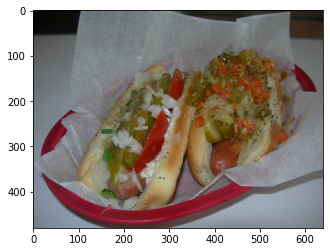

Q: What is the name of the items the hot dog are topped with?
C: a hot dog with ketchup and mustard on a bun
A: ketchup and mustard (score:0.6615136861801147)
GT: ['relish', 'onion relish', 'condiment', 'vegetable']


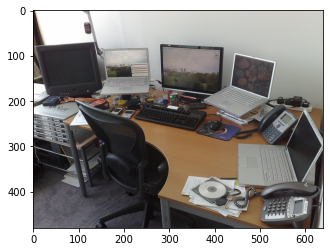

Q: What is this desk used for?
C: a cluttered desk with a computer and a keyboard
A: legal offices (score:0.4201202690601349)
GT: ['work', 'compute', 'office']


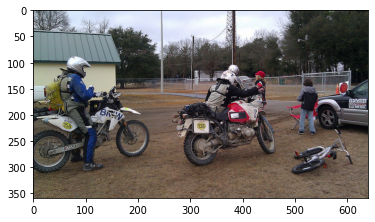

Q: What type of bike is on the ground?
C: motorcycles are parked in a parking lot
A: motorcycle (score:0.06811436265707016)
GT: ['bicycle', 'bmx', '10 speed']


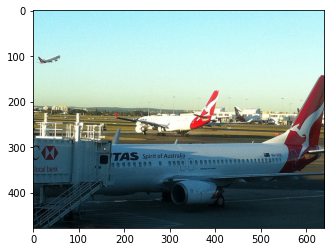

Q: What type of plane is that?
C: a large jetliner sitting on top of an airport tarmac
A: jetliner (score:0.12996317446231842)
GT: ['md 80', 'quanta', 'passenger', 'commercial']


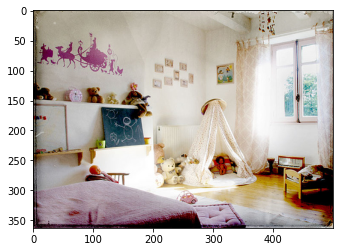

Q: Is this a room for a boy or girl?
C: a living room with a christmas tree in the corner
A: Death is the permanent termination of all biological processes which sustain an organism (score:0.21354922652244568)
GT: ['girl']


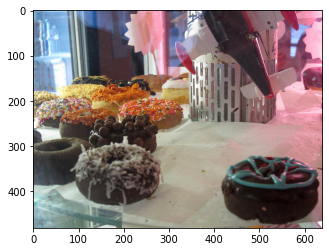

Q: In what year was this desert first introduced?
C: a table topped with lots of different types of donuts
A: 1950 (score:0.021037118509411812)
GT: ['1860', '1934', '1847', '1900s']


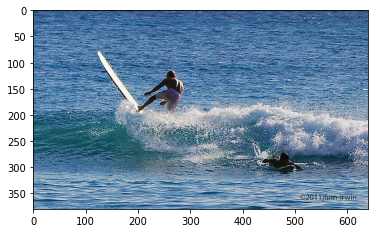

Q: What is this surf trick called?
C: a man riding a wave on top of a surfboard
A: spinning top (score:0.5159270763397217)
GT: ['ollie', 'ride', 'wave runner', 'tube ride']


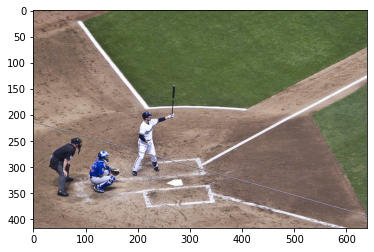

Q: What do they call running around the bases on a single hit?
C: a batter, catcher and umpire during a baseball game
A: runs (score:0.4691186249256134)
GT: ['homerun', 'home run']


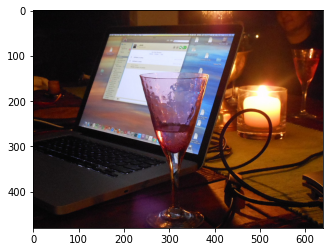

Q: Why is this plugged in?
C: a laptop computer sitting on top of a wooden table
A: A computer system (score:0.29947376251220703)
GT: ['outlet', 'charge', 'power', 'to have power and work']


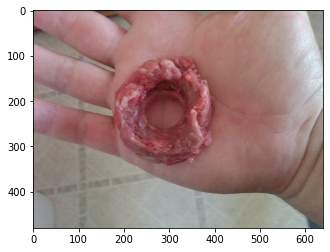

Q: What is the shape?
C: a hand holding a piece of food in it's other hand
A: queen (score:0.1552836000919342)
GT: ['round', 'circle']


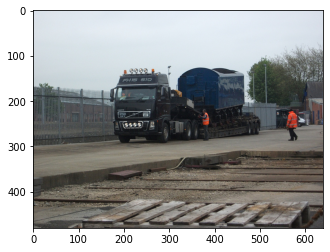

Q: What is the horsepower of the truck pulling the load?
C: a truck carrying a large load on the back of it
A: n (score:0.03776616230607033)
GT: ['500', '510', '420']


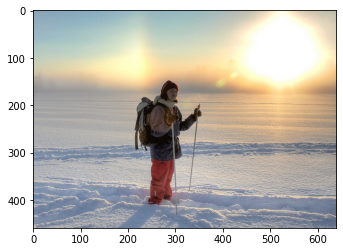

Q: What kind of skiing is this person engaged in?
C: a woman standing on top of a snow covered slope
A: m=\tan(\theta (score:0.028397170826792717)
GT: ['cross country']


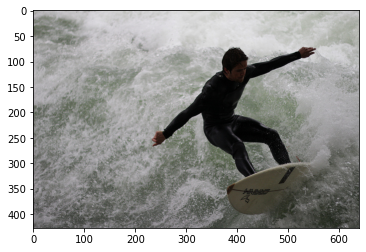

Q: What is the person in the photo wearing?
C: a man riding a wave on top of a surfboard
A: transparent (score:0.0929441750049591)
GT: ['wetsuit', 'trunk', 'wet suit', 'suit']


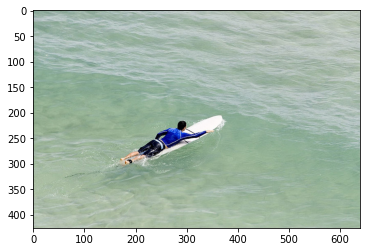

Q: What is the name of the board he is on?
C: a man riding a wave on top of a surfboard
A: papa he'e nalu (score:0.2526634931564331)
GT: ['surfboard', 'surf', 'surf board']


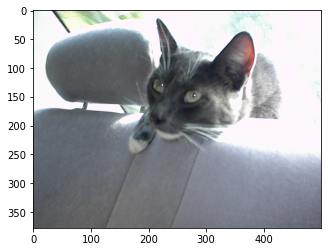

Q: Name the material used to make this car seat shown in this picture?
C: a cat is sitting on the seat of a car
A: financed (score:0.19794102013111115)
GT: ['nylon', 'leather', 'polyester', 'cloth']


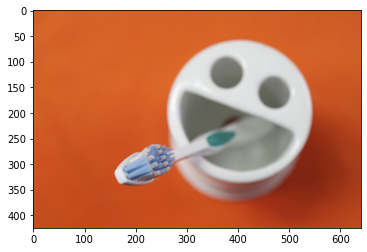

Q: What part of the face is the toothbrush in?
C: a toothbrush holder with a toothbrush in it
A: mouth (score:0.3611474931240082)
GT: ['happy', 'mouth']


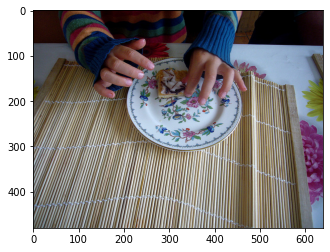

Q: What flavor is this pastry?
C: a small child is eating a piece of cake
A: meringues (score:0.7095164656639099)
GT: ['chocolate', 'blueberry', 'strawberry', 'cream cheese']


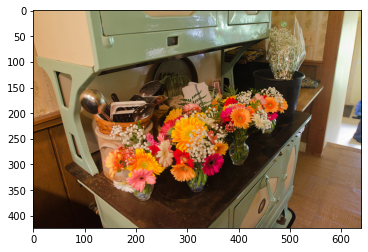

Q: What kind of container are the flowers in?
C: a vase filled with flowers sitting on top of a stove
A: vase (score:0.6199836730957031)
GT: ['vase', 'pot', 'trolley']


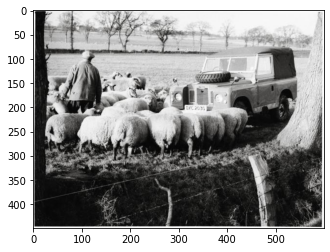

Q: What country does this appear to be?
C: a herd of sheep standing next to a truck
A: Canada, and Mexico (score:0.13479940593242645)
GT: ['usa', 'england', 'scotland']


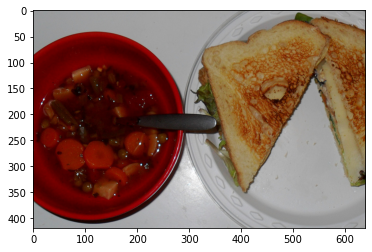

Q: Which of the foods in the picture is best for you to eat when you have a cold?
C: a white plate topped with a sandwich and a bowl of soup
A: bowl (score:0.25905847549438477)
GT: ['soup', 'chicken soup', 'fruit']


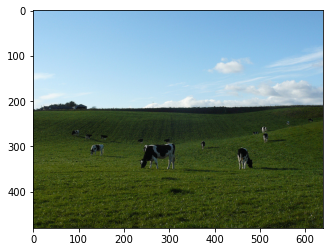

Q: What do teenage pranksters do to this animal?
C: a herd of cattle grazing on a lush green field
A: predation (score:0.05756867304444313)
GT: ['tip']


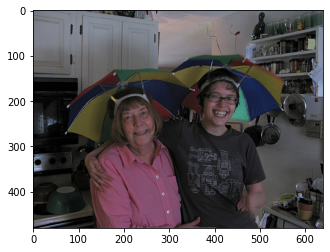

Q: How many watts is that microwave?
C: two people with umbrellas standing in a kitchen
A: A people is any plurality of persons considered as a whole (score:1.267080006073229e-05)
GT: ['1000', '800', '100', '120']


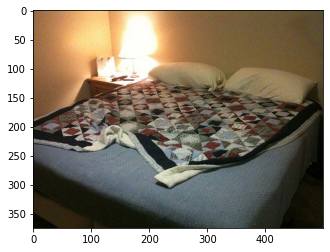

Q: What is this type of blanket called?
C: a bed with a blanket and pillows on it
A: bedding (score:0.8725814819335938)
GT: ['patchwork', 'quilt']


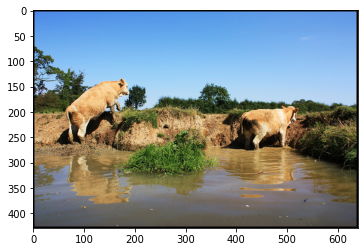

Q: What south american country usually has this climate?
C: two brown and white elephants walking through a river
A: Scotland (score:0.42777925729751587)
GT: ['brazil', 'africa', 'ecuador']


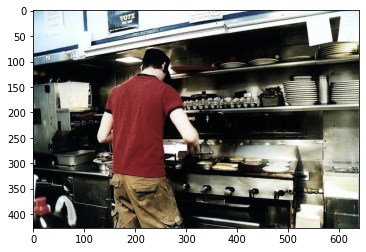

Q: What american restaurant features an open kitchen with visible cooking area such as this?
C: a man standing in a kitchen preparing food
A: Food and Drug Administration (score:0.628257155418396)
GT: ['waffle house', 'diner', "denny's"]


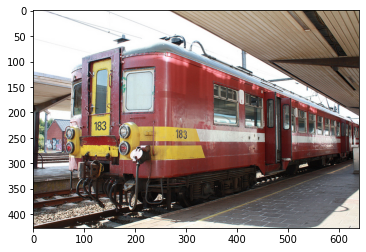

Q: What other big vehicle is often painted about the same shade as this vehicle?
C: a train on a train track near a platform
A: Monorails (score:0.44748419523239136)
GT: ['firetruck', 'fire truck']


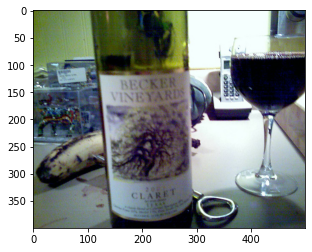

Q: What brand is this wine?
C: a bottle of wine sitting next to a bottle of wine
A: Red (score:0.16993571817874908)
GT: ['becker', 'becker vineyard']


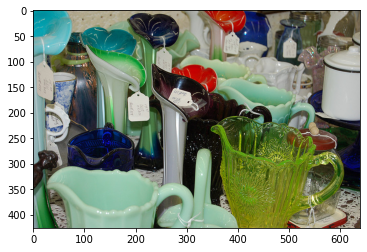

Q: What would happen if these items fall to the ground?
C: a collection of vases sitting on top of a counter
A: roll on its side (score:0.3554189205169678)
GT: ['shatter', 'they would shatter', 'break', 'they would break']


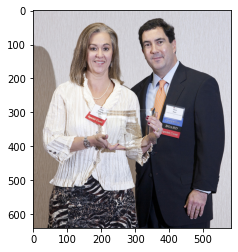

Q: What brand of suit is the man in the image wearing?
C: a man and a woman posing for a picture
A: A man is an adult male human (score:0.009238863363862038)
GT: ['name brand', 'gorgio armani', 'gucchi', 'brook brother']


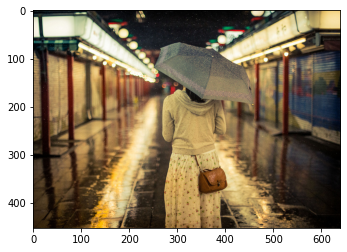

Q: Where might i buy a print that resembles this photo?
C: a woman walking down a street holding an umbrella
A: discount stores (score:0.34485605359077454)
GT: ['walmart', 'store', 'gallery', 'target']


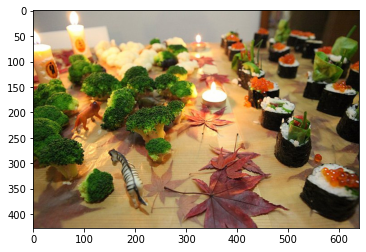

Q: What are the rolled black food items called?
C: a table topped with lots of different types of food
A: Food is any substance consumed to provide nutritional support for an organism (score:0.03337159752845764)
GT: ['sushi']


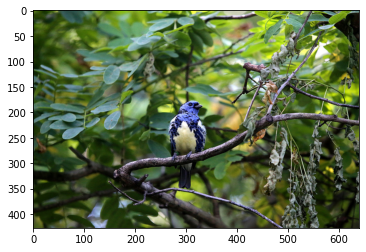

Q: What type of bird is this?
C: a bird sitting on a branch in a tree
A: Neornithes (score:0.845117449760437)
GT: ['bluebird', 'blue jay', 'songbird', 'goldfinch']


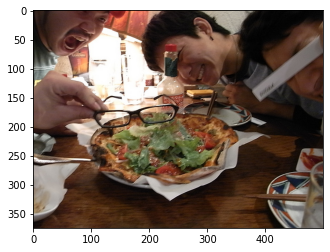

Q: How can you tell that the people are not upset?
C: a man sitting at a table with a pizza in front of him
A: held in the hand (score:0.10260903835296631)
GT: ['they are smile', 'smile']


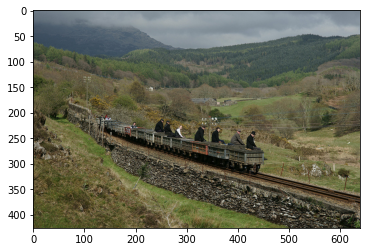

Q: How fast is the vehicle pictured capable of reaching?
C: people riding on the back of a train
A: higher speeds (score:0.19204102456569672)
GT: ['80 mph', '10mph', '100 mph']


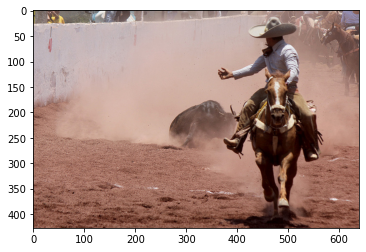

Q: Name the type of hat the man is wearing?
C: a man riding on the back of a brown horse
A: spirited " (score:0.01677802763879299)
GT: ['sombrero', 'stetson', 'cowboy']


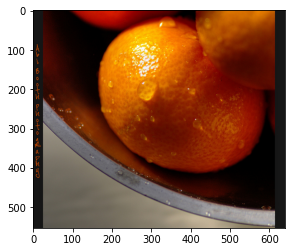

Q: What sates are these grown in?
C: a bowl filled with oranges in a bowl
A: tropical and subtropical climates (score:0.67586350440979)
GT: ['florida california', 'california', 'florida']


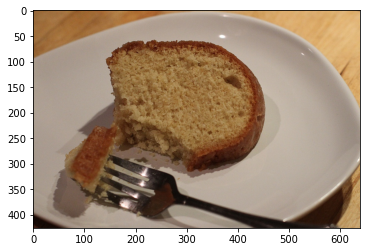

Q: How does the bread taste?
C: a piece of cake sitting on top of a white plate
A: bread-like (score:0.3841533660888672)
GT: ['good', 'sweet', 'delicious', 'like bread']


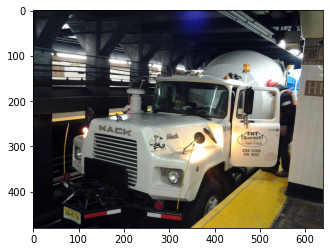

Q: What is this type of mack truck used for?
C: a large white truck parked in a warehouse
A: transport cargo, carry specialized payloads, or perform other utilitarian work (score:0.28634777665138245)
GT: ['cement', 'road work']


In [34]:
for i in range(50):
    display(HTML(f"<h2>Prediction {i}</h2>"))
    mk_predictions(i)